In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

df = pd.read_json('..\\datasets\\headlines.json', lines=True)
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [3]:
df = df[['headline', 'category']]
df

,headline,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS
...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH
209523,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS
209524,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS


In [4]:
df_headline_len = df['headline'].apply(lambda x: len(str(x).split(' ')))
df_headline_len

0         11
1         13
2         13
3          9
4         11
          ..
209522     8
209523    10
209524    17
209525     8
209526     9
Name: headline, Length: 209527, dtype: int64

                mean: 9.60
       harmonic mean: 8.29


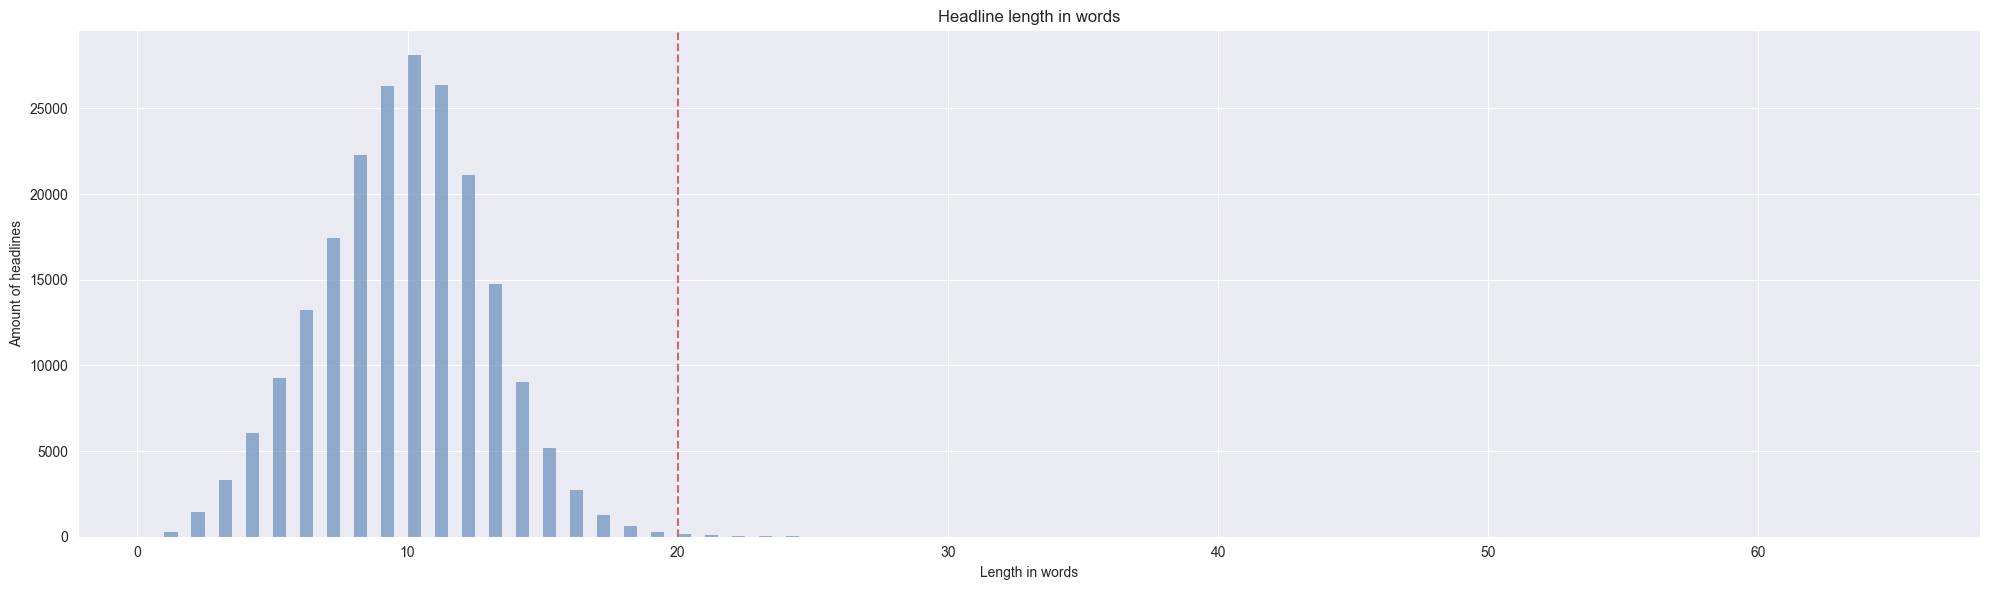

In [5]:
from matplotlib import pyplot as plt
from scipy.stats import hmean
import seaborn as sb

mid_blue = '#6f93bf'
mid_red = '#bf6f6f'

max_headline_len = 20

harmonic_headline_mean = hmean(df_headline_len)
headline_mean = df_headline_len.mean()

print(
    f"{"mean":>20}: {headline_mean:.2f}",
    f"{"harmonic mean":>20}: {harmonic_headline_mean:.2f}", sep='\n'
)

fig, axes = plt.subplots(figsize=(20, 6))

axes.set_title('Headline length in words')
axes.set_xlabel('Length in words')
axes.set_ylabel('Amount of headlines')
sb.histplot(df_headline_len, ax=axes, binwidth=0.5, linewidth=0, color=mid_blue)
axes.axvline(x=max_headline_len, color=mid_red, linestyle='--', label='cutoff')

plt.tight_layout()

Beautiful gaussian curve.

In [6]:
cut_to = lambda length: df_headline_len <= length
shorter_than_20 = len(df[cut_to(20)])
longer_than_20 = len(df) - len(df[cut_to(20)])

print(
    "Amount of headlines",
    f"  shorter/equal to 20: {shorter_than_20:_}",
    f"       longer than 20: {longer_than_20:_}", sep='\n'
)

Amount of headlines
  shorter/equal to 20: 209_302
       longer than 20: 225


Since we're going to train our model on most average headline length. <br>
I don't see any point to use such small fraction of data. <br>
It can be very problematic for training our model. So we can safely remove it.

In [7]:
df = df[cut_to(max_headline_len)]

In [8]:
df_headline_len = df['headline'].apply(lambda x: len(str(x).split(' ')))
df_headline_len

0         11
1         13
2         13
3          9
4         11
          ..
209522     8
209523    10
209524    17
209525     8
209526     9
Name: headline, Length: 209302, dtype: int64

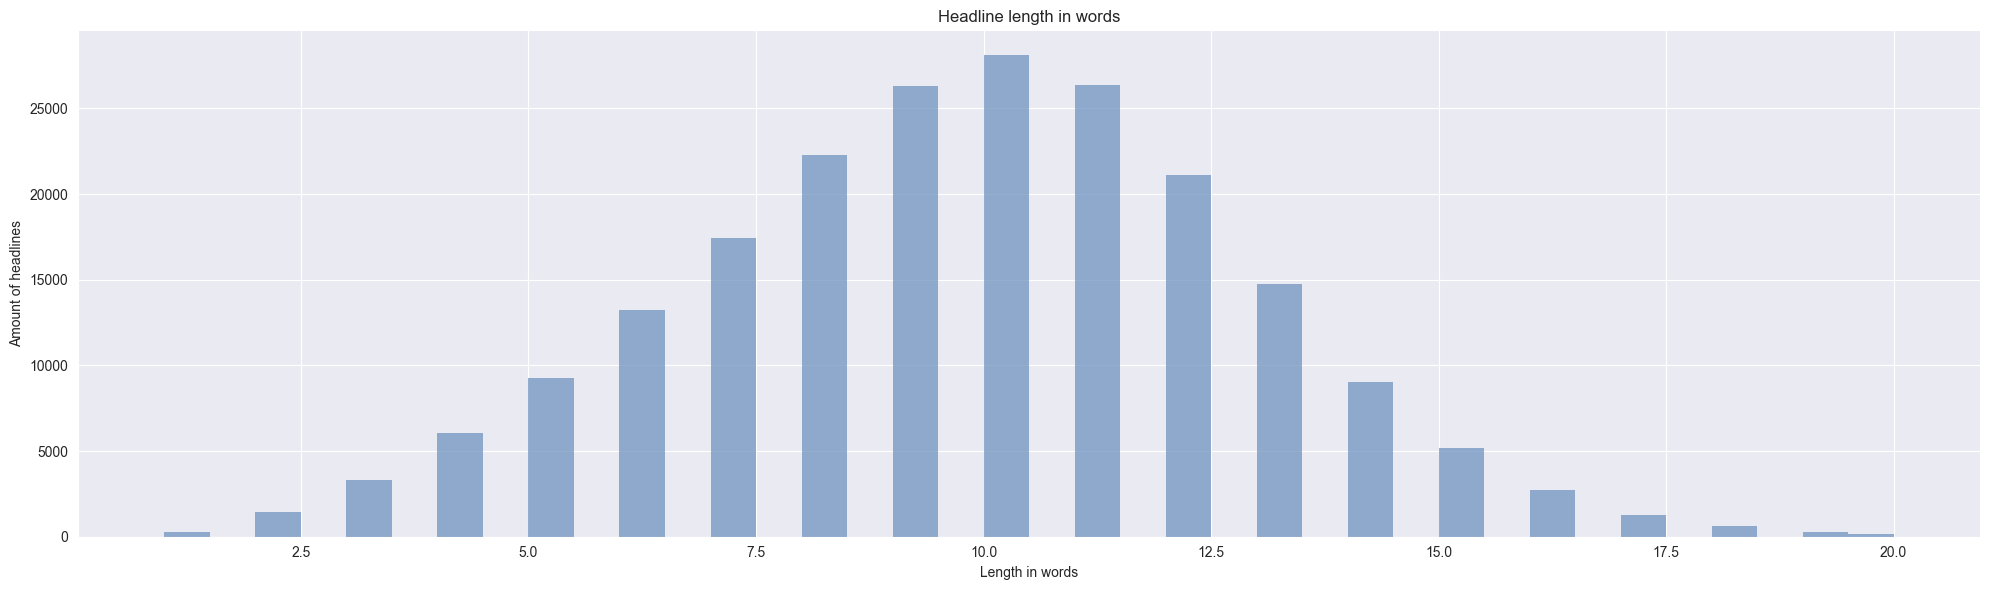

In [9]:
from matplotlib import pyplot as plt
import seaborn as sb

mid_blue = '#6f93bf'
mid_red = '#bf6f6f'

max_headline_len = 20

fig, axes = plt.subplots(figsize=(20, 6))

axes.set_title('Headline length in words')
axes.set_xlabel('Length in words')
axes.set_ylabel('Amount of headlines')
sb.histplot(df_headline_len, ax=axes, binwidth=0.5, linewidth=0, color=mid_blue)

plt.tight_layout()

#### Tokenizing headlines

In [10]:
import re

def text_clean(text):
    result = text.lower()
    result = re.sub(r'[^a-zA-Z\s]', '', result)
    result = re.sub(r' +', ' ', result)
    return result

In [11]:
sample = '!@#this is "a   "sample! (T*eXt)...'
print(
    f"Before: {sample}",
    f"After: {text_clean(sample)}", sep='\n'
)

Before: !@#this is "a   "sample! (T*eXt)...
After: this is a sample text


In [12]:
df['headline'] = df['headline'].apply(lambda x: text_clean(str(x)))
df

,headline,category
0,over million americans roll up sleeves for omi...,U.S. NEWS
1,american airlines flyer charged banned for lif...,U.S. NEWS
2,of the funniest tweets about cats and dogs th...,COMEDY
3,the funniest tweets from parents this week sept,PARENTING
4,woman who called cops on black birdwatcher los...,U.S. NEWS
...,...,...
209522,rim ceo thorsten heins significant plans for b...,TECH
209523,maria sharapova stunned by victoria azarenka i...,SPORTS
209524,giants over patriots jets over colts among mos...,SPORTS
209525,aldon smith arrested ers linebacker busted for...,SPORTS


min: 1007
max: 35556


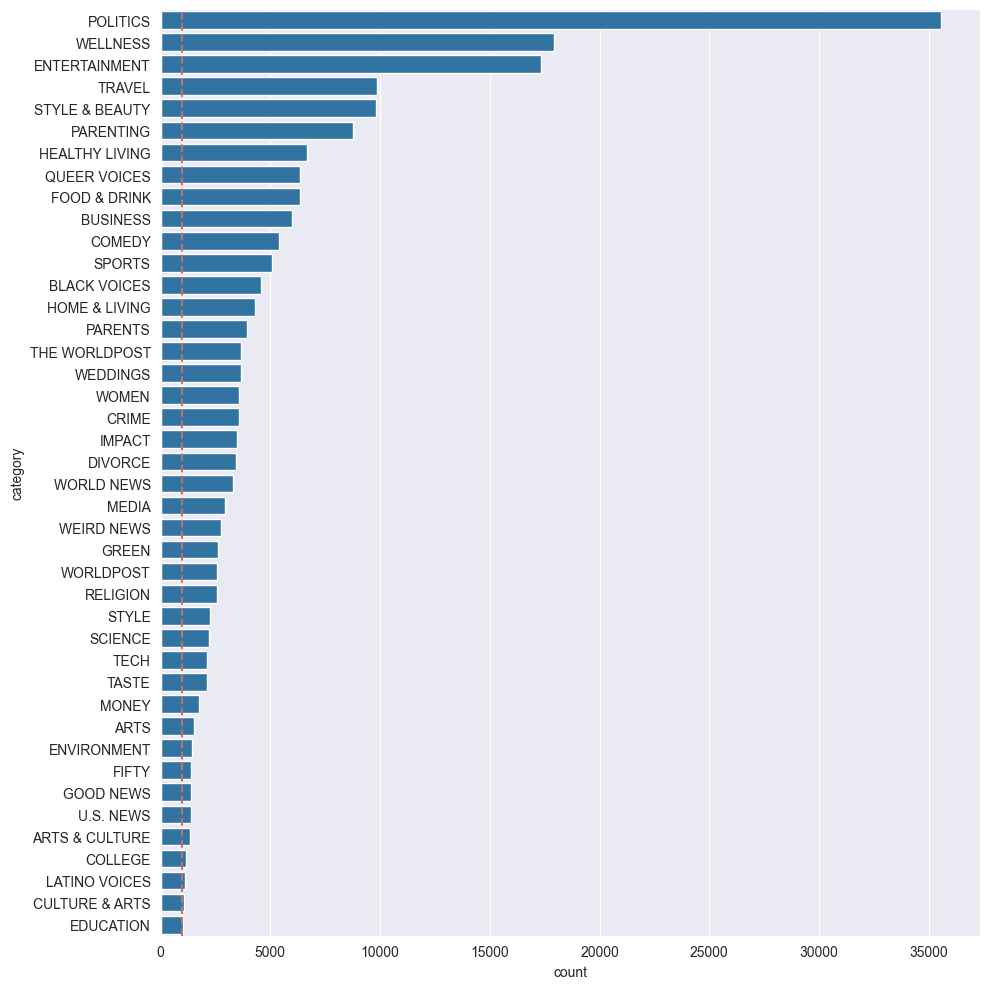

In [13]:
sorted_categories = df['category'].value_counts().index

fig, axes = plt.subplots(figsize=(10, 10))

print(
    f"min: {df['category'].value_counts().min()}",
    f"max: {df['category'].value_counts().max()}", sep='\n'
)

sb.countplot(df['category'], order=sorted_categories)
axes.axvline(x=1_000, color=mid_red, linestyle='--')
plt.tight_layout()

#### Labeling categories

In [14]:
category_to_label = {
    cat: i for i, cat in enumerate(sorted_categories)
}

category_to_label

{'POLITICS': 0,
 'WELLNESS': 1,
 'ENTERTAINMENT': 2,
 'TRAVEL': 3,
 'STYLE & BEAUTY': 4,
 'PARENTING': 5,
 'HEALTHY LIVING': 6,
 'QUEER VOICES': 7,
 'FOOD & DRINK': 8,
 'BUSINESS': 9,
 'COMEDY': 10,
 'SPORTS': 11,
 'BLACK VOICES': 12,
 'HOME & LIVING': 13,
 'PARENTS': 14,
 'THE WORLDPOST': 15,
 'WEDDINGS': 16,
 'WOMEN': 17,
 'CRIME': 18,
 'IMPACT': 19,
 'DIVORCE': 20,
 'WORLD NEWS': 21,
 'MEDIA': 22,
 'WEIRD NEWS': 23,
 'GREEN': 24,
 'WORLDPOST': 25,
 'RELIGION': 26,
 'STYLE': 27,
 'SCIENCE': 28,
 'TECH': 29,
 'TASTE': 30,
 'MONEY': 31,
 'ARTS': 32,
 'ENVIRONMENT': 33,
 'FIFTY': 34,
 'GOOD NEWS': 35,
 'U.S. NEWS': 36,
 'ARTS & CULTURE': 37,
 'COLLEGE': 38,
 'LATINO VOICES': 39,
 'CULTURE & ARTS': 40,
 'EDUCATION': 41}

In [15]:
df['category'] = df['category'].apply(lambda cat: category_to_label[cat])
df

,headline,category
0,over million americans roll up sleeves for omi...,36
1,american airlines flyer charged banned for lif...,36
2,of the funniest tweets about cats and dogs th...,10
3,the funniest tweets from parents this week sept,5
4,woman who called cops on black birdwatcher los...,36
...,...,...
209522,rim ceo thorsten heins significant plans for b...,29
209523,maria sharapova stunned by victoria azarenka i...,11
209524,giants over patriots jets over colts among mos...,11
209525,aldon smith arrested ers linebacker busted for...,11


In [16]:
from collections import Counter

tokenized_texts = [headline.split() for headline in df['headline']]
word_counts = Counter([word for headline in tokenized_texts
                            for word in headline])
word_counts.most_common(10)

[('the', 63324),
 ('to', 52552),
 ('of', 33273),
 ('a', 32394),
 ('in', 31900),
 ('for', 25437),
 ('and', 24363),
 ('is', 17895),
 ('on', 17393),
 ('with', 13781)]

In [17]:
word_to_idx = {word: i+1 for i, (word, _) in enumerate(word_counts.most_common())}
word_to_idx['<PAD>'] = 0
idx_to_word = {i: word for word, i in word_to_idx.items()}

for i in range(10):
    print(idx_to_word[i])

<PAD>
the
to
of
a
in
for
and
is
on


In [18]:
sequences = [[word_to_idx[word] for word in headline.split()] for headline in df['headline']]
sequences[:10]

[[49, 204, 214, 1952, 43, 19072, 6, 36951, 958, 16149],
 [138, 1094, 9105, 993, 2039, 6, 64, 27, 8056, 902, 5532, 9, 26],
 [3, 1, 804, 295, 21, 1710, 7, 670, 19, 74, 6916],
 [1, 804, 295, 18, 151, 19, 74, 6916],
 [125, 50, 868, 481, 9, 83, 28677, 1480, 833, 117, 36952],
 [8295, 75, 165, 5, 28678, 1526, 6, 269, 166, 371, 294, 118],
 [1171, 149, 499, 731, 18, 45, 1936, 306, 190, 9, 284],
 [1307, 11461, 3224, 6, 419, 27, 721, 36953, 7632],
 [15, 4, 17, 1497, 1852, 1, 12638, 3, 134, 4, 195, 3, 1303],
 [457, 16, 629, 2, 297, 520, 194, 38, 21316, 2, 11003, 4394]]

In [19]:
import numpy as np

padded_sequences = []

for seq in sequences:
    pad_seq = np.pad(seq, pad_width=(0, max_headline_len - len(seq)))
    padded_sequences.append(pad_seq)
    
padded_sequences = np.array(padded_sequences, dtype=np.int64)

In [20]:
padded_sequences[:10]

array([[   49,   204,   214,  1952,    43, 19072,     6, 36951,   958,
        16149,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [  138,  1094,  9105,   993,  2039,     6,    64,    27,  8056,
          902,  5532,     9,    26,     0,     0,     0,     0,     0,
            0,     0],
       [    3,     1,   804,   295,    21,  1710,     7,   670,    19,
           74,  6916,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [    1,   804,   295,    18,   151,    19,    74,  6916,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [  125,    50,   868,   481,     9,    83, 28677,  1480,   833,
          117, 36952,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [ 8295,    75,   165,     5, 28678,  1526,     6,   269,   166,
          371,   294,   118,     0,     0,     0,     0,     0,     0,
            0,     0],
       [ 1

In [21]:
train_size = int(len(padded_sequences) * 0.7)

labels = df['category']

train_split = (padded_sequences[:train_size], labels[:train_size])
test_split = (padded_sequences[train_size:], labels[train_size:])

In [22]:
len(test_split[0]) + len(train_split[0]) == len(df)

True

In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def return_loader(dataset):

    sequences, labels = dataset
        
    x, y = [], []
    
    for sequence, label in zip(sequences, labels):
        x.append(sequence)
        y.append(label)
        
    tensor_dataset = TensorDataset(torch.tensor(x).long(),
                                   torch.tensor(y).long())
    
    return DataLoader(tensor_dataset, batch_size=32, drop_last=True)

In [24]:
train_loader  = return_loader(dataset=train_split)
test_loader = return_loader(dataset=test_split)

In [25]:
i = 0

for batch in test_loader:
    inputs, targets = batch
    print(inputs[i], targets[i])
    
    break

tensor([   1,  467,    3,  138, 1186,    7,  478, 8878,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]) tensor(19)


In [26]:
from torch import nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.embedding(x)
        rnn_out, hidden = self.rnn(x)
        output = self.fc(hidden[0][-1])
        
        return output

In [27]:
torch.device('cuda') if torch.cuda.is_available() else 'cpu'

device(type='cuda')

In [40]:
from torch import optim

def train_model(model, data_loader, n_epochs=1, learning_rate=0.001):
    
    device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epochs):
        
        model.train()
        total_loss = 0
        
        for i, batch in enumerate(data_loader):
            inputs, targets = batch
            inputs, targets = (inputs.to(device).long(),
                               targets.to(device).long())
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            loss.backward()
            
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(data_loader)
        
        print(
            f"Epoch: {epoch+1} / {n_epochs}  |  loss: {avg_loss:.4f}"
        )

In [41]:
rnn_model = RNN(vocab_size=len(word_to_idx),
                embed_size=50,
                hidden_size=64,
                output_size=42)

In [42]:
train_model(
    model=rnn_model,
    data_loader=train_loader,
    n_epochs=20,
    learning_rate=0.001
)

Epoch: 1 / 20  |  loss: 2.7471
Epoch: 2 / 20  |  loss: 2.7409
Epoch: 3 / 20  |  loss: 2.3979
Epoch: 4 / 20  |  loss: 2.0008
Epoch: 5 / 20  |  loss: 1.7271
Epoch: 6 / 20  |  loss: 1.5198
Epoch: 7 / 20  |  loss: 1.3561
Epoch: 8 / 20  |  loss: 1.2171
Epoch: 9 / 20  |  loss: 1.0946
Epoch: 10 / 20  |  loss: 0.9843
Epoch: 11 / 20  |  loss: 0.8842
Epoch: 12 / 20  |  loss: 0.7946
Epoch: 13 / 20  |  loss: 0.7160
Epoch: 14 / 20  |  loss: 0.6486
Epoch: 15 / 20  |  loss: 0.5900
Epoch: 16 / 20  |  loss: 0.5374
Epoch: 17 / 20  |  loss: 0.4910
Epoch: 18 / 20  |  loss: 0.4532
Epoch: 19 / 20  |  loss: 0.4180
Epoch: 20 / 20  |  loss: 0.3896


In [43]:
def test_model(model, data_loader):

    device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
    model.to(device)

    model.eval()

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device).long(), targets.to(device).long()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total_correct += torch.sum(predicted == targets).item()
            total_samples += targets.size(0)

    accuracy = total_correct / total_samples
    print(f'Accuracy: {accuracy:.4f}')


In [59]:
def test_model(model, data_loader):

    device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
    model.to(device)

    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device).long(), targets.to(device).long()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

In [60]:
y_true, y_pred = test_model(model=rnn_model, data_loader=test_loader)

In [61]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.64      0.64      0.64     14388
           2       0.23      0.40      0.29      1419
           3       0.52      0.52      0.52      6278
           4       0.59      0.58      0.59      8361
           5       0.52      0.59      0.55      6977
           6       0.00      0.00      0.00         0
           7       0.44      0.55      0.49      1065
           8       0.60      0.54      0.56      4994
           9       0.30      0.26      0.28      1447
          10       0.28      0.29      0.29      1032
          11       0.35      0.51      0.42       503
          12       0.17      0.10      0.12       607
          13       0.30      0.23      0.26      3793
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.63      0.46      0.53      3131
          17       0.00    

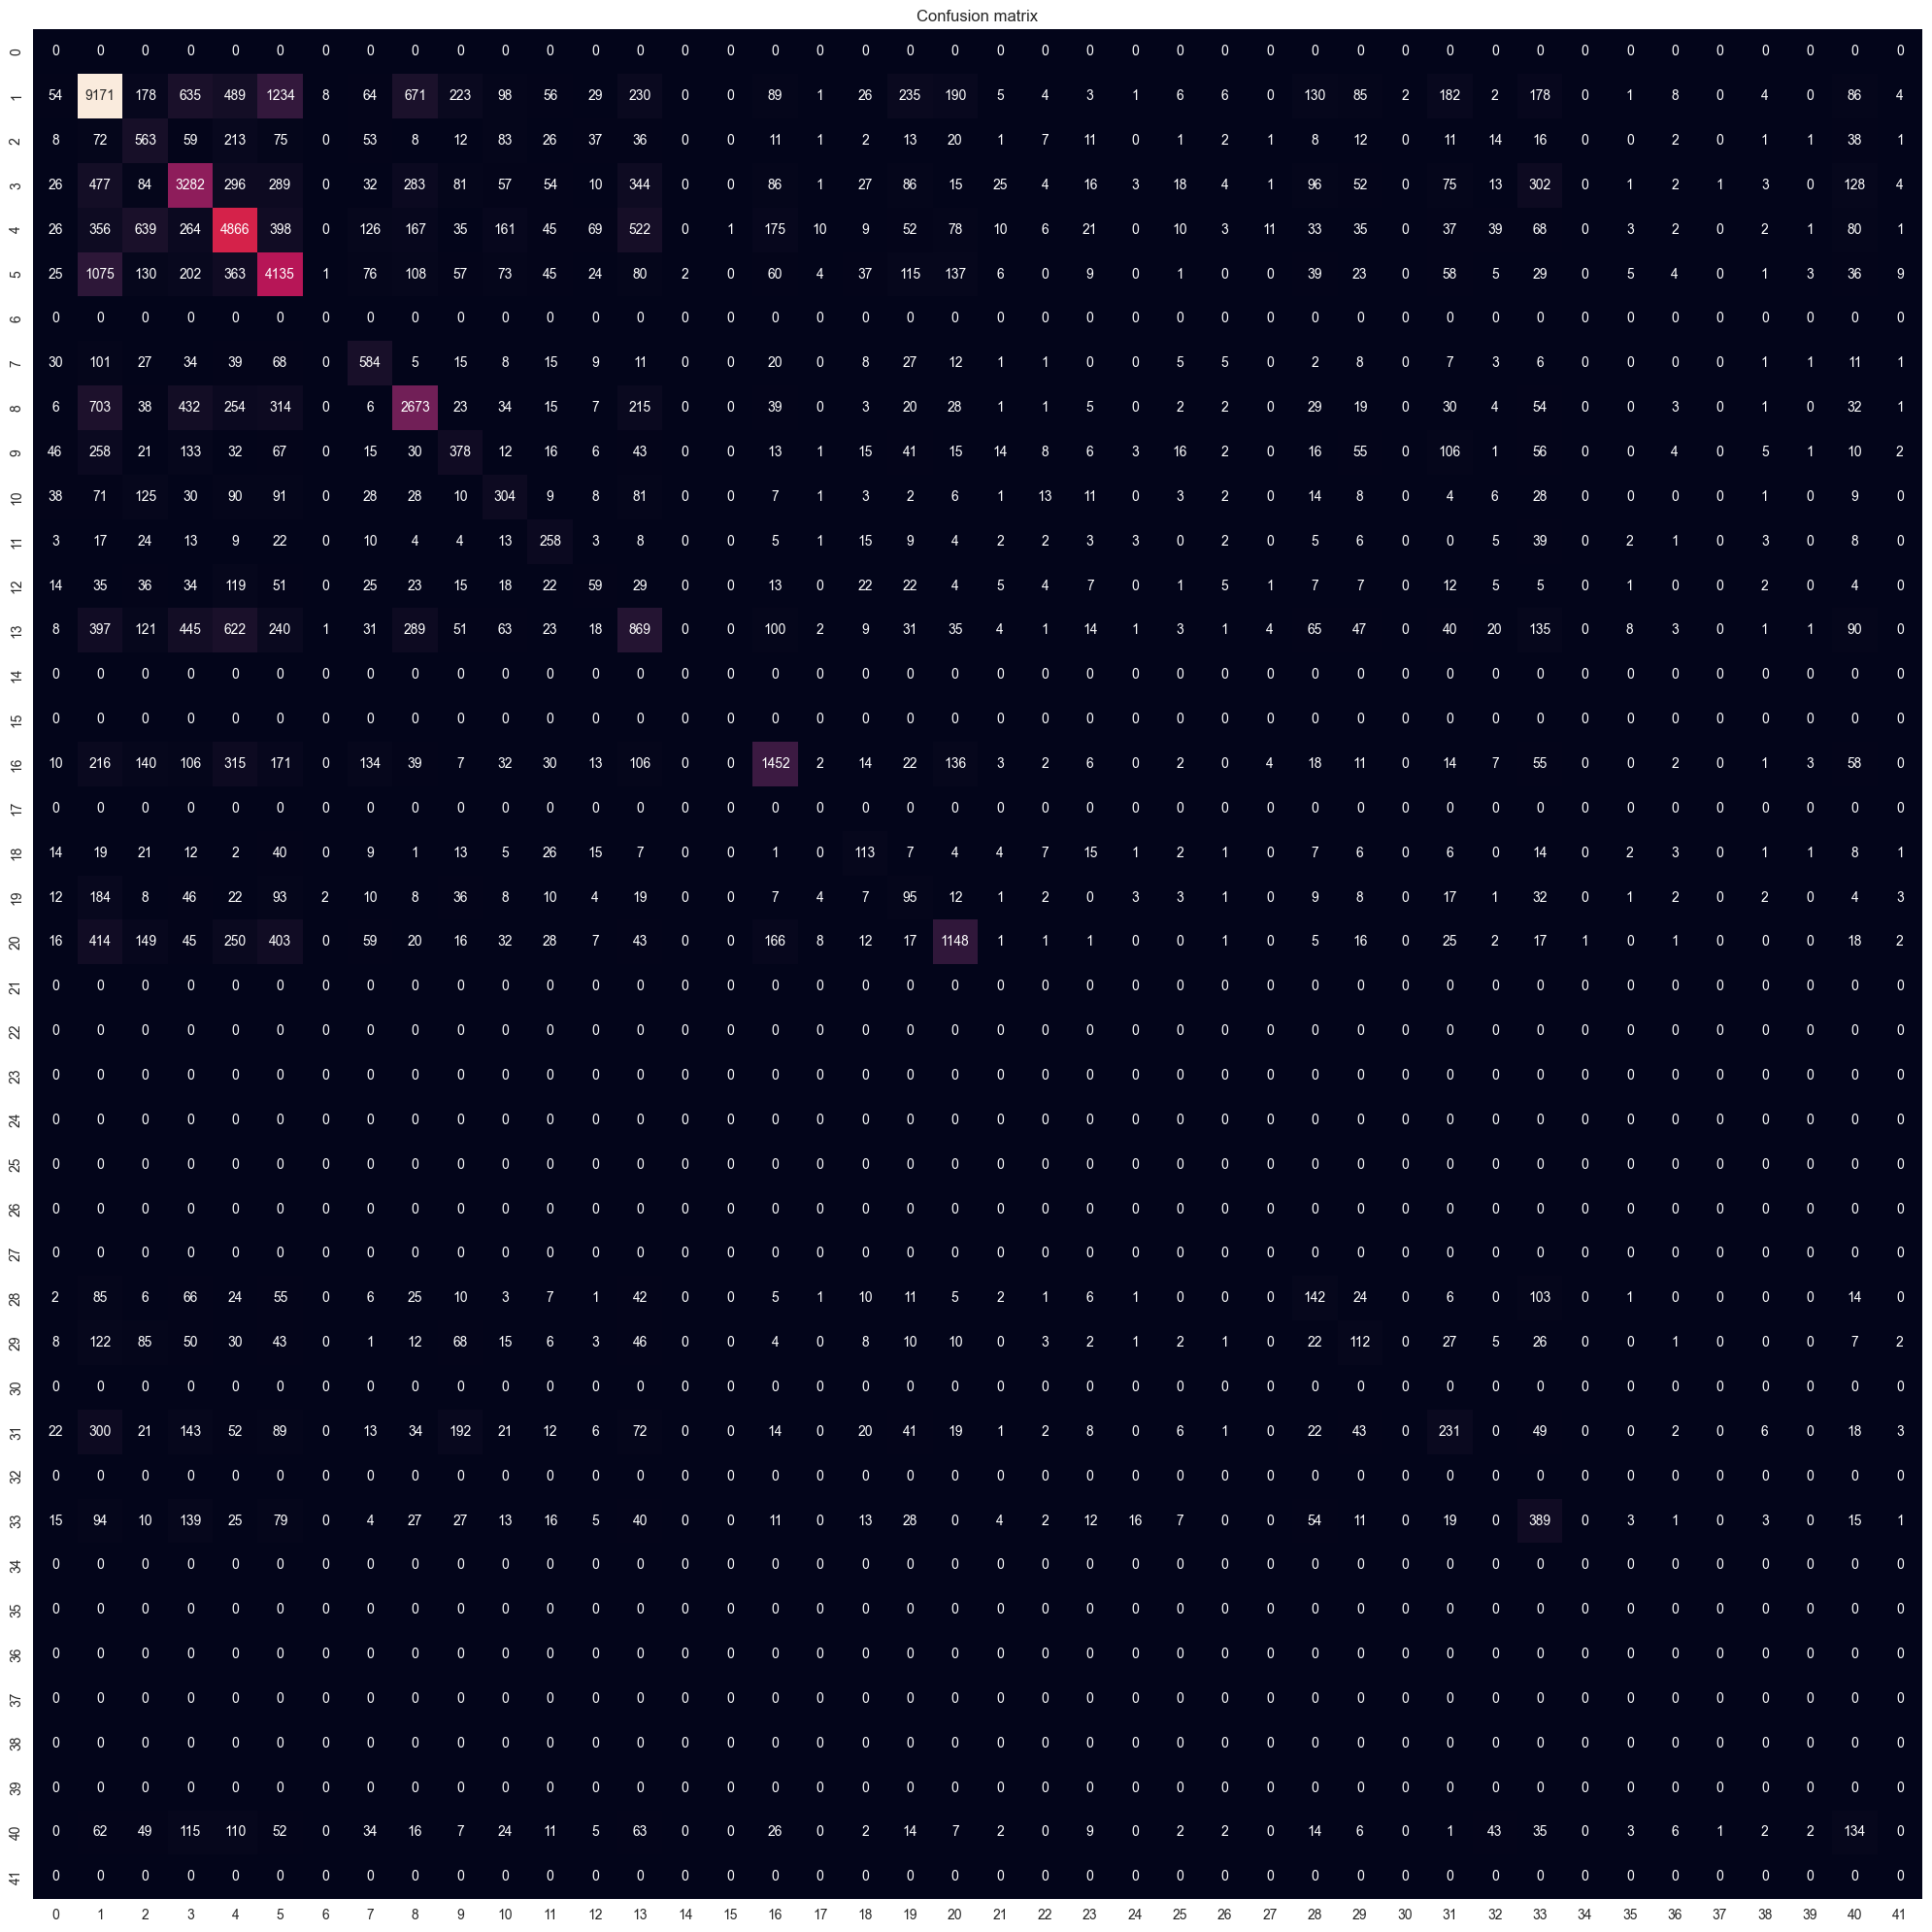

In [62]:
fig, ax = plt.subplots(figsize=(20, 20))

sb.heatmap(cm, fmt='d', annot=True, cbar=False)
plt.title('Confusion matrix')
plt.tight_layout()